## Introduction

I'll be taking advantage of Tensorflow's Object Detection API to rapidly train an traffic object detection model via transfer learning that will efficiently run on Edge TPUs.

## Change Tensorflow Version

I have to change from TF 2.* to 1.* because pretrained quantized models compatible with EDGE TPU are only available on TF 1.*

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Confirming TF version**

In [2]:
import tensorflow as tf

print(tf.__version__)

1.15.2


**Mount Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


output_directory = '/content/drive/My Drive/Colab Notebooks/Data/Herbie/Saved Models/'
repository_url = 'https://github.com/maldonadojsm/Herbie'

Mounted at /content/drive


**As before, this function will help me now when training has completed via email**

In [5]:
import smtplib, ssl
from email.message import EmailMessage

def send_email(message: str):
    """
    Send message to indicated email address once training has been completed.
    @ param message: email message
    """
    with open('/content/drive/My Drive/Colab Notebooks/pw.txt') as f:
        data = f.readlines()

    user_name = "maldonadojsm@gmail.com"
    pw = data[0]

    sender_email = user_name
    receiver_email = "maldonadojsm@gmail.com"

    email = EmailMessage()
    email.set_content(message)
    email['Subject'] = "Google Colab"
    email['From'] = sender_email
    email['To'] = receiver_email
    
    context = ssl.create_default_context()

    try:

        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.ehlo()
        server.starttls(context=context)
        server.ehlo()
        server.login(user_name, pw)
        server.send_message(email)

    except Exception as e:
        print(e)

    finally:
        server.quit()


## Pretrained Model Selection & Hyperparameter Configuration

I'll be selecting a pretrained model from the [Tensorflow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models). In this case I'll be selecting the **ssd_mobilenet_v2_quantized** model because I plan to increase the rate of inferences by using an [Edge TPU](https://coral.ai/products/?gclid=CjwKCAiAo5qABhBdEiwAOtGmbo_D5s2Il6BFt02Vdlg3GfHAjEWOWVkGS6fRbOwg2SDsPHpQ1Z4PCxoCVyYQAvD_BwE) (Edge TPU also require quantized models).

In [6]:
# Number of training steps.
num_steps = 2000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## **Clone TensorFlow Model Garden Repository & Installing Object Detection API**

I'll be harnessing the models and training workflow offered by the Tensorflow Model Garden to efficiently train an object detection model via transfer learning. As such, the training workflow (gathering data, preprocessing and training) will mostly be processed using the Tensorflow Object Detection CLI API. 

To begin, I'll first ensure that I'm able to build, configure and run models offered by the Model Garden repository

In [7]:
import os
import sys

# Change to this direcotry and Store Model Garden Repo here
%cd /content/drive/My Drive/Colab Notebooks/Data/Herbie

# Clone Herbie Repository (I need to access two scripts for TF Record Preperation)
repository_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repository_url)))
!git clone {repository_url}

# Clone Model Garden Repo
!git clone --quiet https://github.com/tensorflow/models.git

# Change to this direcotry
%cd /content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf1/setup.py .
!python -m pip install .

#Test to check that I'm able to build and configure models in model garden
!python object_detection/builders/model_builder_tf1_test.py

/content/drive/My Drive/Colab Notebooks/Data/Herbie
fatal: destination path 'Herbie' already exists and is not an empty directory.
fatal: destination path 'models' already exists and is not an empty directory.
/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research
Processing /content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research
     |████████████████████████████████| 358kB 17.0MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1608645 sha256=9b3ed15a791c3972d5bcffa2bcd0c2c60cd25213ab25767b2abc41cc9c3603f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-p_w_dxuz/wheels/ad/2a/0d/9fd2ea9a0638b92dd04ba9acdd86a19c37a8bd0d9d532794cb
Successfully built object-detection
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuild

## Preparing Training Test Data & TF Record Files

Given that the mission is to train an object detection model that is able to recongize traffic objects, I need to generate a data set containing pictures of such objects.

Example:

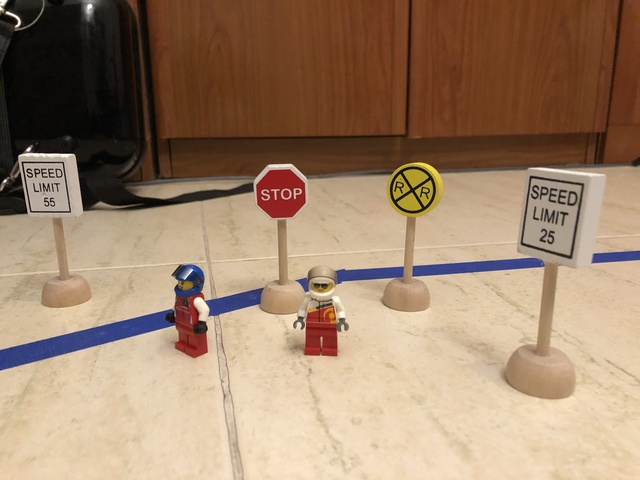

I took around 50 pictures with similar objects as these and labelled them using [LabelImg](https://github.com/tzutalin/labelImg). This program allows user to very rapidly label objects in pictures, storing label information in XML format.

In addition, the Tensorflow Object Detection API requires datasets to be in TF Record format. Before generating the TF Record, I need to convert the XML files storing the object labels into csv files and then feed those csv files to a python script that will extract label maps (label of object, and bounding box) of each instance, finally storing all instance as a TF Record.

In [18]:
S%cd /content/drive/My Drive/Colab Notebooks/Data/Herbie/Herbie/src
!git pull

# Convert and merge .xml annotation files into single .csv file
!python xml_to_csv.py -i "/content/drive/My Drive/Colab Notebooks/Data/Herbie/images/train" -o "/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/training_labels.csv" -l "/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations" 

!python xml_to_csv.py -i "/content/drive/My Drive/Colab Notebooks/Data/Herbie/images/test" -o "/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/testing_labels.csv" 

# Generate TF Record for testing data
!python gen_tfrecord.py \
    --csv_input="/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/training_labels.csv" \
    --output_path="/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/training.record" \
    --img_path="/content/drive/My Drive/Colab Notebooks/Data/Herbie/images/train" \
    --label_map "/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/label_map.pbtxt" 

!python gen_tfrecord.py \
    --csv_input="/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/testing_labels.csv" \
    --output_path="/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/testing.record" \
    --img_path="/content/drive/My Drive/Colab Notebooks/Data/Herbie/images/test" \
    --label_map "/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/label_map.pbtxt" 


/content/drive/My Drive/Colab Notebooks/Data/Herbie/Herbie/src
Already up to date.
Successfully converted xml to csv.
Generate `/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/label_map.pbtxt`
Successfully converted xml to csv.

W0122 11:47:49.784999 140471394699136 module_wrapper.py:139] From gen_tfrecord.py:112: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

Successfully created the TFRecords: /content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/training.record

W0122 11:48:05.442087 139902653691776 module_wrapper.py:139] From gen_tfrecord.py:112: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

Successfully created the TFRecords: /content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/testing.record


In [19]:
test_record_filepath = '/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/testing.record'
training_record_filepath = '/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/training.record'
label_map_pbtxt_filepath = '/content/drive/My Drive/Colab Notebooks/Data/Herbie/Traffic Object Detection/annotations/label_map.pbtxt'

## Download Model

In [20]:
%cd /content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research


import os
import shutil
import glob
import urllib.request
import tarfile

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research


**Confirm model was downloaded successfully**

In [21]:
!echo '/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/pretrained_model'
!ls -alh '/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/pretrained_model'


/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/pretrained_model
total 204M
-rw------- 1 root root  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw------- 1 root root  68K Jan  4  2019 model.ckpt.index
-rw------- 1 root root  20M Jan  4  2019 model.ckpt.meta
-rw------- 1 root root 4.3K Jan  4  2019 pipeline.config
-rw------- 1 root root  24M Jan  4  2019 tflite_graph.pb
-rw------- 1 root root  68M Jan  4  2019 tflite_graph.pbtxt


In [22]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/pretrained_model/model.ckpt'

## Configuring The Pipeline

Now that I've downloaded the model that I want to use from the model zoo, I'll now have to configure the training pipeline file that defines things such as the train/test datasets, number of classes that it should identify, label map of classes, epochs, learning rate and etc

In [23]:
import os
pipeline_fname = os.path.join('/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

**Extract total number of classes found in .pbtxt file**

In [24]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

**Update Pipeline Config File with our paramaters**

In [25]:
import re

# This script is based on the samples provided in Tensorflow repository

num_classes = get_num_classes(label_map_pbtxt_filepath)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # Set Model Checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # Set paths so they point to the train and test TF records 
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(training_record_filepath), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_filepath), s)

    # Set file path pointing to label_map file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_filepath), s)

    # Set training batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set number of training steps per epoch
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes that will be trained
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

**Start Training**

In [27]:

send_email("DL Object Detection Training Start")
%cd /content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/object_detection/
!python model_main.py \
    --pipeline_config_path='{pipeline_fname}' \
    --model_dir='{output_directory}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps} 
send_email("DL Object Detection Training Completed")

(534, b'5.7.14 <https://accounts.google.com/signin/continue?sarp=1&scc=1&plt=AKgnsbu\n5.7.14 7Nb4uuDtgeUUap1rt_54s4JIMxJodZKxm7ARqNH5TT3uA5jlapYJReXJ1VZdvpNZ4Ff3Y\n5.7.14 fi60w4lididrfMM9uu7AjLKSCAL1vajX9yAktNnu_lBlHsdNYySkZP5a3gVoTFsB>\n5.7.14 Please log in via your web browser and then try again.\n5.7.14  Learn more at\n5.7.14  https://support.google.com/mail/answer/78754 e5sm5624583qtp.86 - gsmtp')
/content/drive/My Drive/Colab Notebooks/Data/Herbie/models/research/object_detection
W0122 11:50:47.991540 139876269782912 model_lib.py:793] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0122 11:50:47.991783 139876269782912 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0122 11:50:47.991905 139876269782912 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0122 11:50:47.991997 1398762697829

**I'm going to select the last model checkpoint given that's the last one returned after trainining**

In [28]:
import os
import re
import numpy as np

tpu_output_directory = '%s/fine_tuned_model' % output_directory
os.makedirs(tpu_output_directory, exist_ok=True)

In [29]:
lst = os.listdir(output_directory)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(output_directory, last_model)
print(last_model_path)

/content/drive/My Drive/Colab Notebooks/Data/Herbie/Saved Models/model.ckpt-2000


**Export Inference Graph**

In [30]:
!python export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path='{pipeline_fname}' \
    --output_directory='{tpu_output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

Instructions for updating:
Please use `layer.__call__` method instead.
W0122 12:08:56.921386 140599551514496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0122 12:08:58.963694 140599551514496 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0122 12:08:59.001890 140599551514496 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0122 12:08:59.038937 140599551514496 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

**Create Tensorflow Lite Graph**

In [31]:

!python export_tflite_ssd_graph.py \
    --pipeline_config_path='{pipeline_fname}' \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{tpu_output_directory}' \
    --add_postprocessing_op=true

Instructions for updating:
Please use `layer.__call__` method instead.
W0122 12:09:16.043853 140616994711424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0122 12:09:18.118647 140616994711424 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0122 12:09:18.145834 140616994711424 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0122 12:09:18.172350 140616994711424 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

**Given that the Edge TPU only accepts quantized models, I need to transform the frozen graph into a quantized TF lite file.**

In [32]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{tpu_output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{tpu_output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2021-01-22 12:09:36.033201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-22 12:09:36.070439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-22 12:09:36.071005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-01-22 12:09:36.071270: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-01-22 12:09:36.074716: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-22 12:09:36.076207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Suc

**I also need to convert the frozen graph to an unquantized TF Lite file because it's necessary when converting the quantized TF Lite file into Edge TPU's TF Lite Format.**

In [33]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{tpu_output_directory}/road_signs_float.tflite' \
  --graph_def_file='{tpu_output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to unquantized TF Lite file...
2021-01-22 12:09:52.700382: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-22 12:09:52.732492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-22 12:09:52.733084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-01-22 12:09:52.733358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-01-22 12:09:52.734984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-22 12:09:52.736490: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] S

In [34]:
print(tpu_output_directory)
!ls -ltra '{tpu_output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(tpu_output_directory), "frozen_inference_graph.pb")  # this is tflite graph
!cp '{label_map_pbtxt_filepath}' '{tpu_output_directory}'

/content/drive/My Drive/Colab Notebooks/Data/Herbie/Saved Models//fine_tuned_model
total 134463
-rw------- 1 root root  2210109 Jan 22 12:09 model.ckpt.meta
-rw------- 1 root root    23543 Jan 22 12:09 model.ckpt.index
-rw------- 1 root root 18857216 Jan 22 12:09 model.ckpt.data-00000-of-00001
-rw------- 1 root root       77 Jan 22 12:09 checkpoint
-rw------- 1 root root 19740475 Jan 22 12:09 frozen_inference_graph.pb
drwx------ 3 root root     4096 Jan 22 12:09 saved_model
-rw------- 1 root root     4357 Jan 22 12:09 pipeline.config
-rw------- 1 root root 54001501 Jan 22 12:09 tflite_graph.pbtxt
-rw------- 1 root root 19342722 Jan 22 12:09 tflite_graph.pb
-rw------- 1 root root  4776952 Jan 22 12:09 road_signs_quantized.tflite
-rw------- 1 root root 18727104 Jan 22 12:09 road_signs_float.tflite


**The final step is to download the road_signs_quantized.tflite file and feed it to the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/#system-requirements) to create an Edge TPU compatible quantized TF Lite file.**